In [50]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.stats import ortho_group
import scipy

In [51]:
data = pd.read_csv("/Users/lucastucker/REU-2023/archive/mnist_train.csv")
data = np.array(data)
np.random.shuffle(data)

In [52]:
data.shape

(60000, 785)

In [53]:
m = 2000 # number of MNIST images sampled
n = 784 # number of pixels per MNIST image
t = 100 # number of neighbors measured
sample = data[:m]
X = sample[:, 1:].T / 255
X.shape

(784, 2000)

In [54]:
def get_random_projection(k, X):
    R = np.random.normal(size = (n, k)) 
    frob_norm = np.linalg.norm(R.dot(R.T).dot(X) - X)
    print(f"for k = {k}, frobenius norm for random projection is {frob_norm}")
    return R.T.dot(X)

In [55]:
def get_pca(k, X):
    mean_centered_data = X - np.mean(X, axis=1, keepdims=True)
    covariance_matrix = np.cov(mean_centered_data) 
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    proj = sorted_eigenvectors[:, :k] # top k minimize the frobenius norm
    frob_norm = np.linalg.norm(proj.dot(proj.T).dot(X) - X)
    print(f"for k = {k}, frobenius norm for normal pca is {frob_norm}")
    reduced_data = np.dot(proj.T, mean_centered_data)
    # print(f"The PCA U is given by {proj}")
    return reduced_data

In [56]:
# This is performed according to the gradient calculated in the paper
# This is averaged gradient descent, O(GR/sqrt(T)) as proved in Lem 6.22
def gradient_pca(k, X, num_iterations, step):

    X = X - np.mean(X, axis=1, keepdims=True)
    num_iter = num_iterations
    proj = ortho_group.rvs(dim=n)[:, :k] # random n x k orthogonal matrix
    norm = np.linalg.norm(proj)
    proj = proj / norm
    frob_norm = math.inf
    summed_vecs = np.zeros((n, k))
    
    while num_iterations > 0:
        DF = 2 * proj.dot(proj.T).dot(X).dot(X.T).dot(proj) - \
        4 * X.dot(X.T).dot(proj) + 2 * X.dot(X.T).dot(proj).dot(proj.T).dot(proj)

        DF = DF / np.linalg.norm(DF) # Keep the gradient matrix normalized

        proj = proj - step * DF # gradient descent step
        num_iterations -= 1
        summed_vecs += proj

    proj = summed_vecs / num_iter    
    U, s, Vh = scipy.linalg.svd(proj, full_matrices=False)
    output = U.dot(Vh)

    frob_norm = np.linalg.norm(output.dot(output.T).dot(X) - X)
    print(f"for k = {k}, frobenius norm for gradient descent pca is {frob_norm}") # the objective function
    # print(f"The optimized U is given by {output}")

    return output.T.dot(X)

In [57]:
def nearest_t_nbrs(t, X):
    t_nearest = np.ones((m, t), dtype=int) * 1
    for id, row in enumerate(X.T):
        dif = X.T - row # get vector representation-wise differences
        norm_indices = np.argsort(np.linalg.norm(dif, axis = 1))
        t_nearest[id] = norm_indices[1: t + 1]
    return t_nearest # returns m x t matrix representing k_nearest

In [58]:
def t_similarity_score(t, X, X_reduced):
    pixelwise_t_nearest = nearest_t_nbrs(t, X)
    reduced_t_nearest = nearest_t_nbrs(t, X_reduced)
    shared_elems_list = []
    for row, row_tilde in zip(pixelwise_t_nearest, reduced_t_nearest):
        set_1 = set(row)
        set_2 = set(row_tilde)
        shared_elem_count = len(set_1.intersection(set_2))
        shared_elems_list.append(shared_elem_count)
    shared_elems = np.array(shared_elems_list) # row-wise intersection counts
    avg_shared = (1/m) * np.sum(shared_elems)
    return (avg_shared / t)

In [59]:
def normal_pca_similarity_score(k_vals):
    rtn_arr = np.arange(0.0, k_vals.size)
    for index, k in enumerate(k_vals):
        X_pca = get_pca(k, X)
        rtn_arr[index] = t_similarity_score(t, X, X_pca)
    return rtn_arr

In [60]:
def random_similarity_score(k_vals):
    rtn_arr = np.arange(0.0, k_vals.size)
    for index, k in enumerate(k_vals):
        X_random = get_random_projection(k, X)
        rtn_arr[index] = t_similarity_score(t, X, X_random)
    return rtn_arr

In [61]:
def gradient_pca_similarity_score(k_vals, num_iterations = 10, step = 1):
    rtn_arr = np.arange(0.0, k_vals.size)
    for index, k in enumerate(k_vals):
        X_gradient = gradient_pca(k, X, num_iterations, step)
        rtn_arr[index] = t_similarity_score(t, X, X_gradient)
    return rtn_arr

In [62]:
k_vals = np.logspace(1, 9, num = 10, base = 2).astype(int)
print(f"k_vals are {k_vals}")

a = normal_pca_similarity_score(k_vals)
print("")

b = random_similarity_score(k_vals)
print("")

c = gradient_pca_similarity_score(k_vals)
print("")

k_vals are [  2   3   6  12  23  43  80 149 276 512]
for k = 2, frobenius norm for normal pca is 378.1637634366036
for k = 3, frobenius norm for normal pca is 365.91529249121413
for k = 6, frobenius norm for normal pca is 284.9854661050001
for k = 12, frobenius norm for normal pca is 231.29836174870874
for k = 23, frobenius norm for normal pca is 187.5062304234303
for k = 43, frobenius norm for normal pca is 146.33539664860643
for k = 80, frobenius norm for normal pca is 106.43830261792672
for k = 149, frobenius norm for normal pca is 71.58343896227741
for k = 276, frobenius norm for normal pca is 39.092629193746525
for k = 512, frobenius norm for normal pca is 6.215763825174489

for k = 2, frobenius norm for random projection is 14941.60650304227
for k = 3, frobenius norm for random projection is 20507.207046015843
for k = 6, frobenius norm for random projection is 29118.621162146774
for k = 12, frobenius norm for random projection is 39218.70785152077
for k = 23, frobenius norm for r

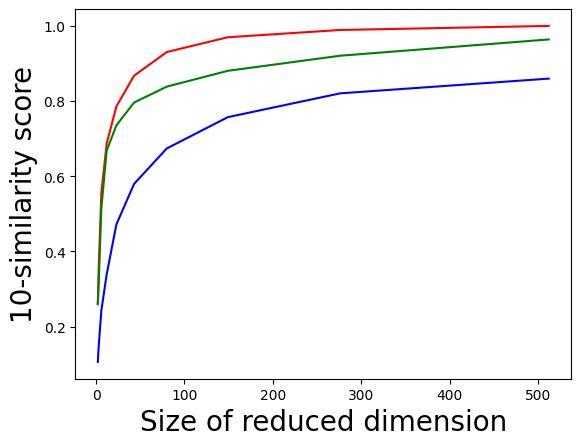

similarity scores for normal pca: [0.26288  0.356085 0.555405 0.68657  0.785355 0.86703  0.92986  0.96915
 0.988475 0.99927 ]
similarity scores for random projection: [0.106255 0.148095 0.24315  0.338775 0.4716   0.579375 0.673595 0.756755
 0.82002  0.859235]
similarity scores for gradient-based pca: [0.25924  0.315945 0.51512  0.66782  0.734995 0.79567  0.837935 0.87994
 0.920045 0.96334 ]


In [63]:
plt.plot(k_vals, a, 'r') # plotting t, a separately 
plt.plot(k_vals, b, 'b') # plotting t, b separately 
plt.plot(k_vals, c, 'g') # plotting t, c separately 
plt.xlabel('Size of reduced dimension', fontsize=20)
plt.ylabel('10-similarity score', fontsize=20)
plt.show()
print(f"similarity scores for normal pca: {a}")
print(f"similarity scores for random projection: {b}")
print(f"similarity scores for gradient-based pca: {c}")

In the above plot, the red (normal pca), green (gradient-based pca), and blue (random projection)
plots depict the level to which the respective dimension reductions preserve the euclidean based
pixelwise distances between MNIST images. 